In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import tifffile as tiff
import numpy as np
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import scipy.signal as sg
sns.set_style('ticks')
import matplotlib.ticker as ticker
%matplotlib inline
%config InlineBackend.figure_format='retina'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Dataset Processing

## Processing YD Dataset

In [2]:
channel_loc = "../Source_data/MM/YFP/analysis/segmented"
color_loc = "../Source_data/MM/YFP/analysis/channels"
channel_file_list=sorted(glob.glob(channel_loc+"/*.tif"))
color_name_list = sorted(glob.glob(color_loc+"/*.tif"))
movie_len = 131
color_list=['blue','yellow']
bgs = np.array([180,100]) # mTurq and YFP backgrounds
max_sig =np.array([550,500])-bgs # Max signals of mTurq and YFP


# initilaize array for storing color info, order is channels,times,cells,colors
# for number of cells I chose specified dims of 15 as never expect more than that
# multiply by -1 as signifies no cell in this point of array

cell_colors=np.ones((len(channel_file_list),
                      movie_len,
                      15,
                      len(color_list))) * -1


# for each segemented channel movie
for k,channel_name in tqdm(enumerate(channel_file_list)):
    # reading files in with all dims
    channel_mask = tiff.imread(channel_name)
    name_split = channel_name.split('/')[-1].split('_')
    name_prefix = '/_'+name_split[1]+'_'+name_split[2]
    color_name_list = [color_loc+name_prefix+'_c2.tif',color_loc+name_prefix+'_c3.tif']
    color_img = tiff.imread(color_name_list)
    res_t,res_y,res_x = channel_mask.shape

    # for each timepoint
    for t in range(0,res_t):
        channel_t = channel_mask[t,:,:]
        n_cells = np.max(channel_t)

        # Segmented output has a pixel value for each cell i.e. Cell 1 has pixel value 1
        # Cell 2 has pixel value 2, etc...
        # for each cell, replace non N cell values with zero, make N cell value 1 
        for n in range(1,n_cells+1):
            sub_mask = np.isin(channel_t,n).astype(np.uint8)

            # for each color channel, apply and retrive median and normalize it
            for i in range(0,len(color_list)):
                masked_img = sub_mask*color_img[i,t,:,:]
                pre_bg_mask = np.nonzero(masked_img)
                median = np.median(masked_img[pre_bg_mask])-bgs[i]
                normed_median = median/max_sig[i]
                cell_colors[k,t,n-1,i] = normed_median

295it [01:06,  4.47it/s]


In [3]:
cell_categorized=np.ones((len(channel_file_list),
                      movie_len,
                      4,)) * -1

movie_len_YD = movie_len

for n in range(0,len(channel_file_list),1):
    for t in range(0,res_t,1):
        # sum both floursence channels
        sum_array = cell_colors[n,t,:,1]+cell_colors[n,t,:,0]
        # Find cells/coordinates with fluor less than 0.2 i.e. dead cells 
        dead_cell_mask = np.logical_and(sum_array>0,sum_array<0.2)
        # calculate ratio of fluor channels (mTurq/YFP), 
        # abs on 2nd channel to keep negatives for empty point/cell slots
        ratio_array = cell_colors[n,t,:,0]/abs(cell_colors[n,t,:,1])
        # apply dead cell mask before counting
        ratio_array[dead_cell_mask] = -2
        # actually count
        blue_count = len(ratio_array[ratio_array>2])
        yellow_count=np.logical_and(ratio_array>0,ratio_array<0.5).sum()
        green_count = np.logical_and(ratio_array<2,ratio_array>0.5).sum()
        dead_cell_count = len(ratio_array[ratio_array==-2])
        cell_categorized[n,t,:] = blue_count,yellow_count,green_count,dead_cell_count

# sum across channels
pop_count_YD = np.sum(cell_categorized,axis=0)


/var/folders/sk/lmgspgwj57bfypl3k_8hs9t40000gn/T/ipykernel_28294/1736012265.py:15: RuntimeWarning: divide by zero encountered in divide
  ratio_array = cell_colors[n,t,:,0]/abs(cell_colors[n,t,:,1])


## Processing TD Dataset

In [4]:
channel_loc = "../Source_data/MM/mTurquoise/analysis/segmented"
color_loc = "../Source_data/MM/mTurquoise/analysis/channels"
channel_file_list=sorted(glob.glob(channel_loc+"/*.tif"))
color_name_list = sorted(glob.glob(color_loc+"/*.tif"))
movie_len = 131
color_list=['blue','yellow']
bgs = np.array([180,100]) # mTurq and YFP backgrounds
max_sig =np.array([550,500])-bgs # Max signals of mTurq and YFP


# initilaize array for storing color info, order is channels,times,cells,colors
# for number of cells I chose specified dims of 15 as never expect more than that
# multiply by -1 as signifies no cell in this point of array

cell_colors=np.ones((len(channel_file_list),
                      movie_len,
                      15,
                      len(color_list))) * -1


# for each segemented channel movie
for k,channel_name in tqdm(enumerate(channel_file_list)):
    # reading files in with all dims
    channel_mask = tiff.imread(channel_name)
    name_split = channel_name.split('/')[-1].split('_')
    name_prefix = '/_'+name_split[1]+'_'+name_split[2]
    color_name_list = [color_loc+name_prefix+'_c2.tif',color_loc+name_prefix+'_c3.tif']
    color_img = tiff.imread(color_name_list)
    res_t,res_y,res_x = channel_mask.shape

    # for each timepoint
    for t in range(0,res_t):
        channel_t = channel_mask[t,:,:]
        n_cells = np.max(channel_t)

        # Segmented output has a pixel value for each cell i.e. Cell 1 has pixel value 1
        # Cell 2 has pixel value 2, etc...
        # for each cell, replace non N cell values with zero, make N cell value 1 
        for n in range(1,n_cells+1):
            sub_mask = np.isin(channel_t,n).astype(np.uint8)

            # for each color channel, apply and retrive median and normalize it
            for i in range(0,len(color_list)):
                masked_img = sub_mask*color_img[i,t,:,:]
                pre_bg_mask = np.nonzero(masked_img)
                median = np.median(masked_img[pre_bg_mask])-bgs[i]
                normed_median = median/max_sig[i]
                cell_colors[k,t,n-1,i] = normed_median

304it [01:09,  4.38it/s]


In [5]:
cell_categorized=np.ones((len(channel_file_list),
                      movie_len,
                      4,)) * -1


for n in range(0,len(channel_file_list),1):
    for t in range(0,res_t,1):
        # sum both floursence channels
        sum_array = cell_colors[n,t,:,1]+cell_colors[n,t,:,0]
        # Find cells/coordinates with fluor less than 0.2 i.e. dead cells 
        dead_cell_mask = np.logical_and(sum_array>0,sum_array<0.2)
        # calculate ratio of fluor channels (mTurq/YFP), 
        # abs on 2nd channel to keep negatives for empty point/cell slots
        ratio_array = cell_colors[n,t,:,0]/abs(cell_colors[n,t,:,1])
        # apply dead cell mask before counting
        ratio_array[dead_cell_mask] = -2
        # actually count
        blue_count = len(ratio_array[ratio_array>2])
        yellow_count=np.logical_and(ratio_array>0,ratio_array<0.5).sum()
        green_count = np.logical_and(ratio_array<2,ratio_array>0.5).sum()
        dead_cell_count = len(ratio_array[ratio_array==-2])
        cell_categorized[n,t,:] = blue_count,yellow_count,green_count,dead_cell_count

# sum across channels
pop_count_TD = np.sum(cell_categorized,axis=0)


/var/folders/sk/lmgspgwj57bfypl3k_8hs9t40000gn/T/ipykernel_28294/391755590.py:14: RuntimeWarning: divide by zero encountered in divide
  ratio_array = cell_colors[n,t,:,0]/abs(cell_colors[n,t,:,1])


# Figure Generation

## Main Figures

### Mother machine trace

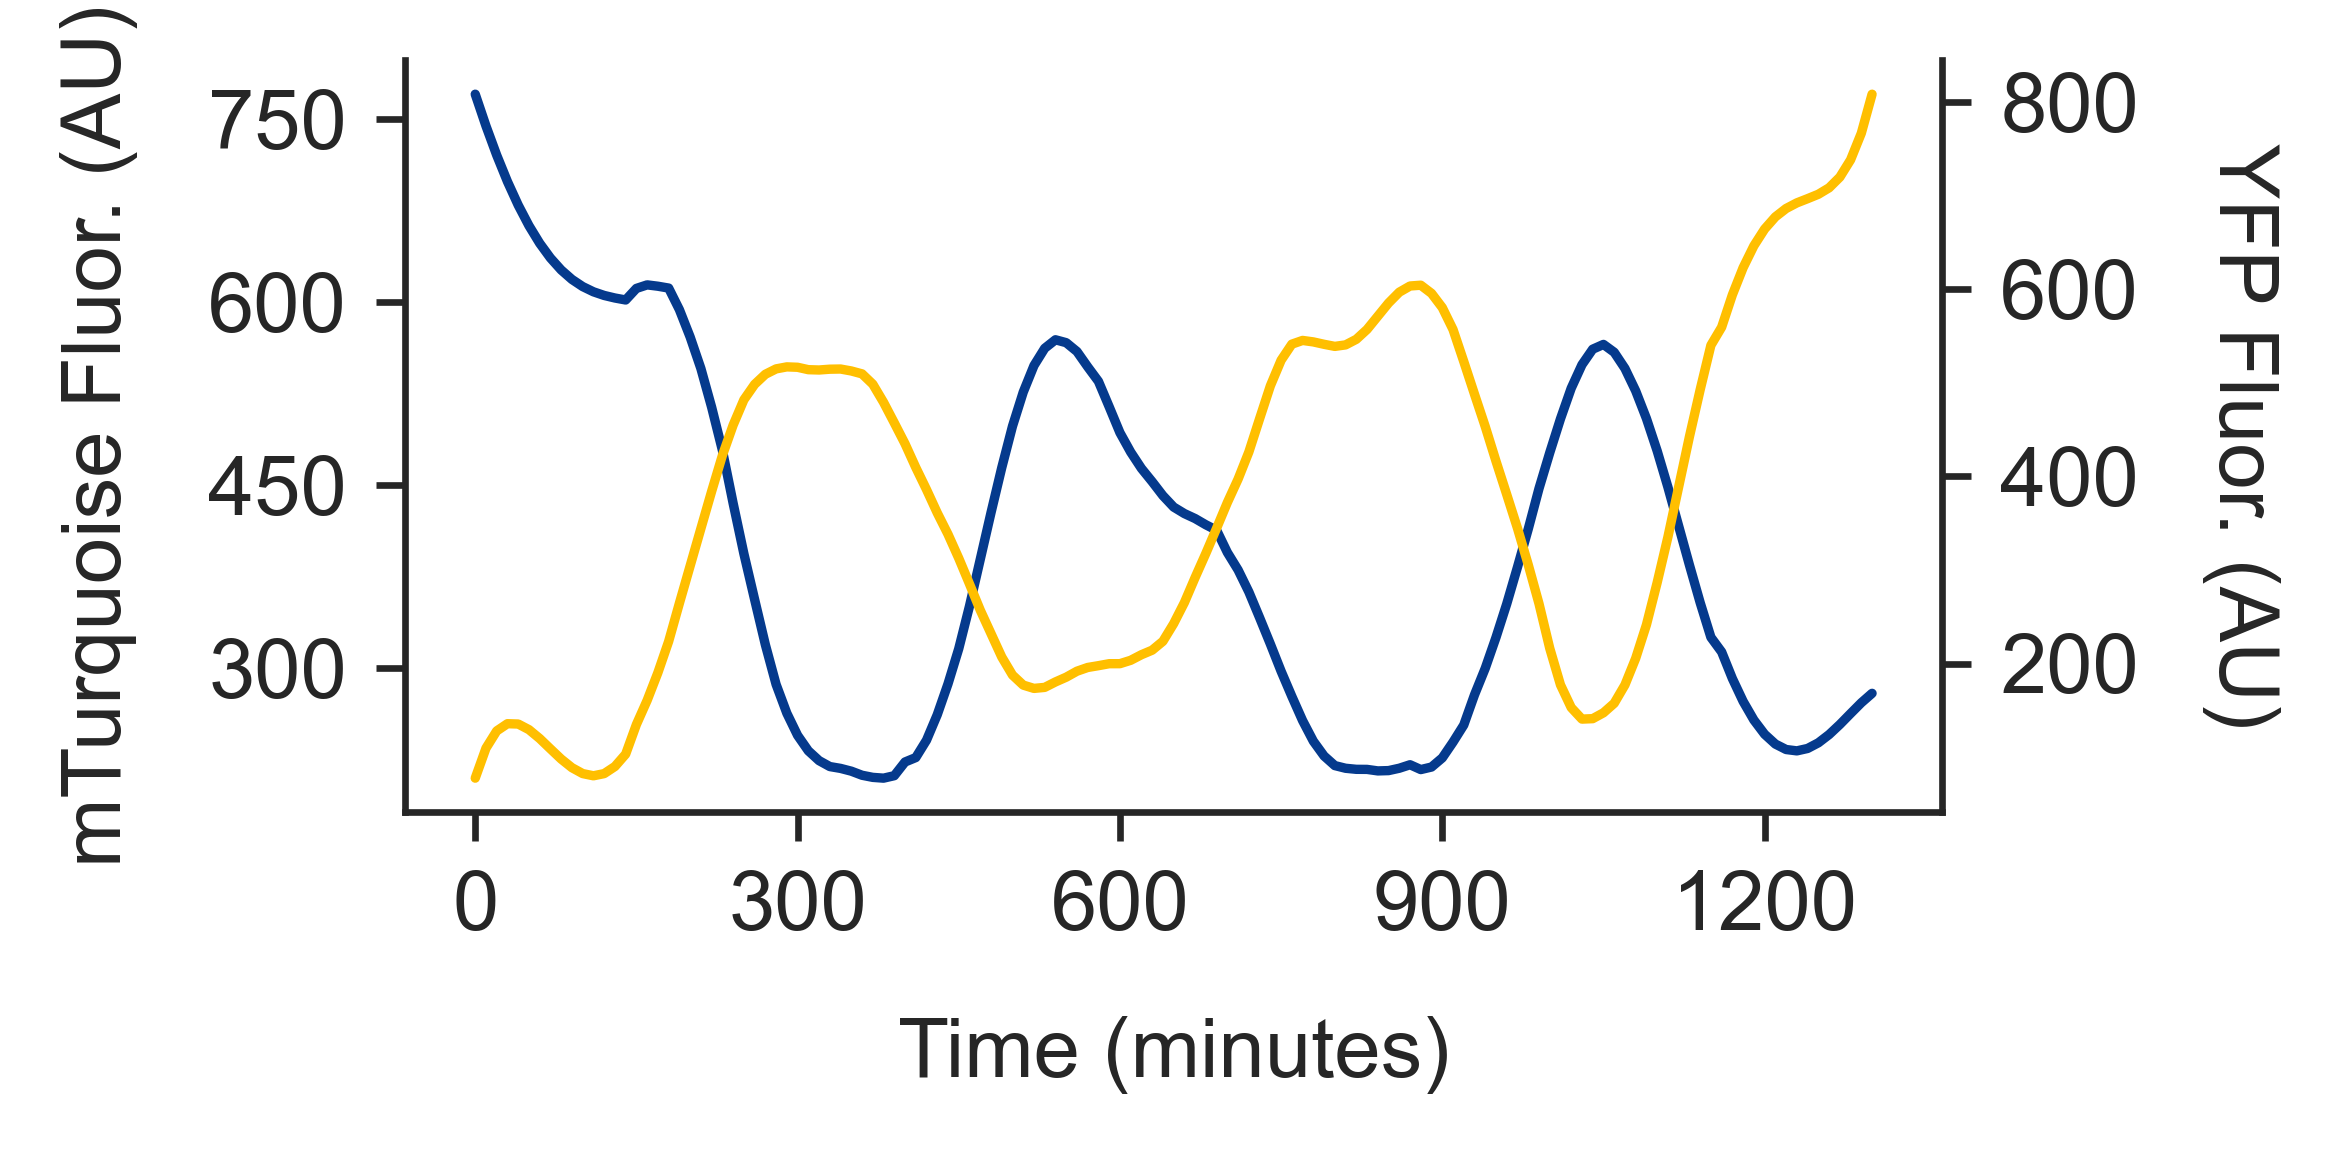

In [6]:
df = pd.read_csv('../Source_data/MM/YFP/film_strip_measurements.csv')

ch1_smoothed = sg.savgol_filter(df['Max'][df['Ch']==1],30,4)
ch2_smoothed = sg.savgol_filter(df['Max'][df['Ch']==2],30,4)

m=9/16

fig,ax = plt.subplots(1,1,figsize=(7.11*m,3.6*m),dpi=300)
ts=np.array(range(0,int(len(df)/2)))*10
ax.plot(ts,ch1_smoothed,lw=2*m,c='#053a8d',label=' ')
ax1 = ax.twinx()
ax1.plot(ts,ch2_smoothed,lw=2*m,c='#ffbf00',label=' ')
ax.set_xlabel('Time (minutes)',size=17.77*m,labelpad=15*m)
ax.set_ylabel('mTurquoise Fluor. (AU)',size=17.77*m,labelpad=15*m)
ax1.set_ylabel('YFP Fluor. (AU)',size=17.77*m,labelpad=30*m,rotation=270)
ax.xaxis.set_major_locator(ticker.MultipleLocator(300))
ax.yaxis.set_major_locator(ticker.MultipleLocator(150))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.tick_params(axis='both', which='major', labelsize=17.77*m)
ax1.tick_params(axis='both', which='major', labelsize=17.77*m)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.tight_layout()

### Switching data

In [7]:
path = '../Source_data/MM/YFP/sw_data_YD.csv'
init_df = pd.read_csv(path)
trans_list = [init_df[str(i)].dropna().to_numpy() for i in range(1,len(init_df.keys()))]
inter_list = []
for n in range(0,len(trans_list)):
    inter = list(np.diff(trans_list[n]))
    inter_list.append(inter)

to_yellow_l = []
to_blue_l = []

for cell in inter_list:
    for i in range(0,len(cell)):
        if i%2 == 0:
            to_blue_l.append(cell[i])
        else:
            to_yellow_l.append(cell[i])

to_yellow = np.array(to_yellow_l)
to_blue = np.array(to_blue_l)

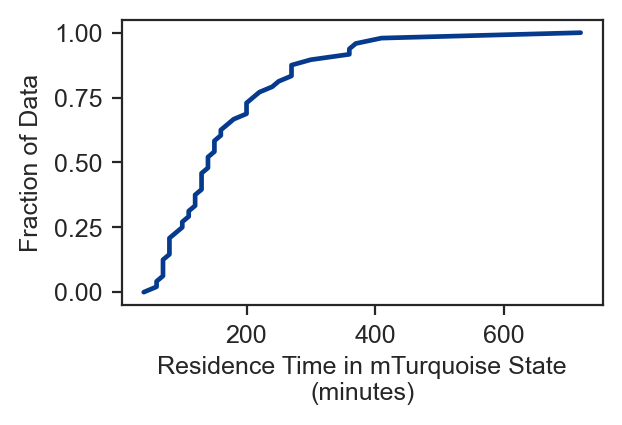

In [8]:
m=9/16
fig,ax = plt.subplots(1,1,figsize=(0.8*7*m,0.8*5*m))
plt.plot(np.sort(to_yellow*10), np.linspace(0, 1, len(to_yellow), endpoint=True),lw=3*m,c='#053a8d')
plt.xlabel('Residence Time in mTurquoise State\n(minutes)', family='Arial',size=16*m,labelpad=5*m)
plt.ylabel('Fraction of Data', family='Arial',size=16*m,labelpad=7*m)
ax.tick_params(axis='both', which='major', labelsize=16*m)
plt.tight_layout()

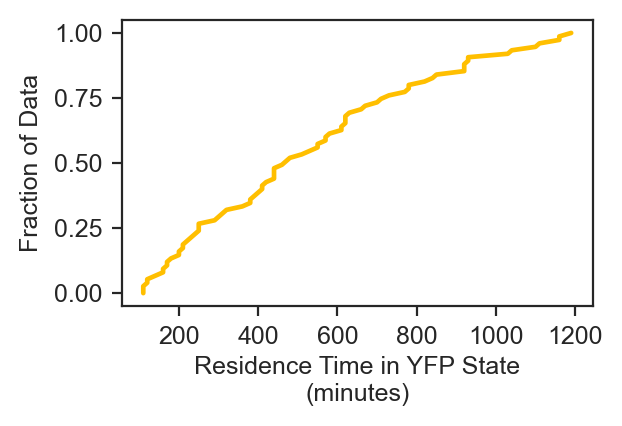

In [9]:
fig,ax = plt.subplots(1,1,figsize=(0.8*7*m,0.8*5*m))
plt.plot(np.sort(to_blue*10), np.linspace(0, 1, len(to_blue), endpoint=True),lw=3*m,c='#ffbf00')
plt.xlabel('Residence Time in YFP State\n(minutes)', family='Arial',size=16*m,labelpad=5*m)
plt.ylabel('Fraction of Data', family='Arial',size=16*m,labelpad=7*m)
ax.tick_params(axis='both', which='major', labelsize=16*m)
plt.tight_layout()

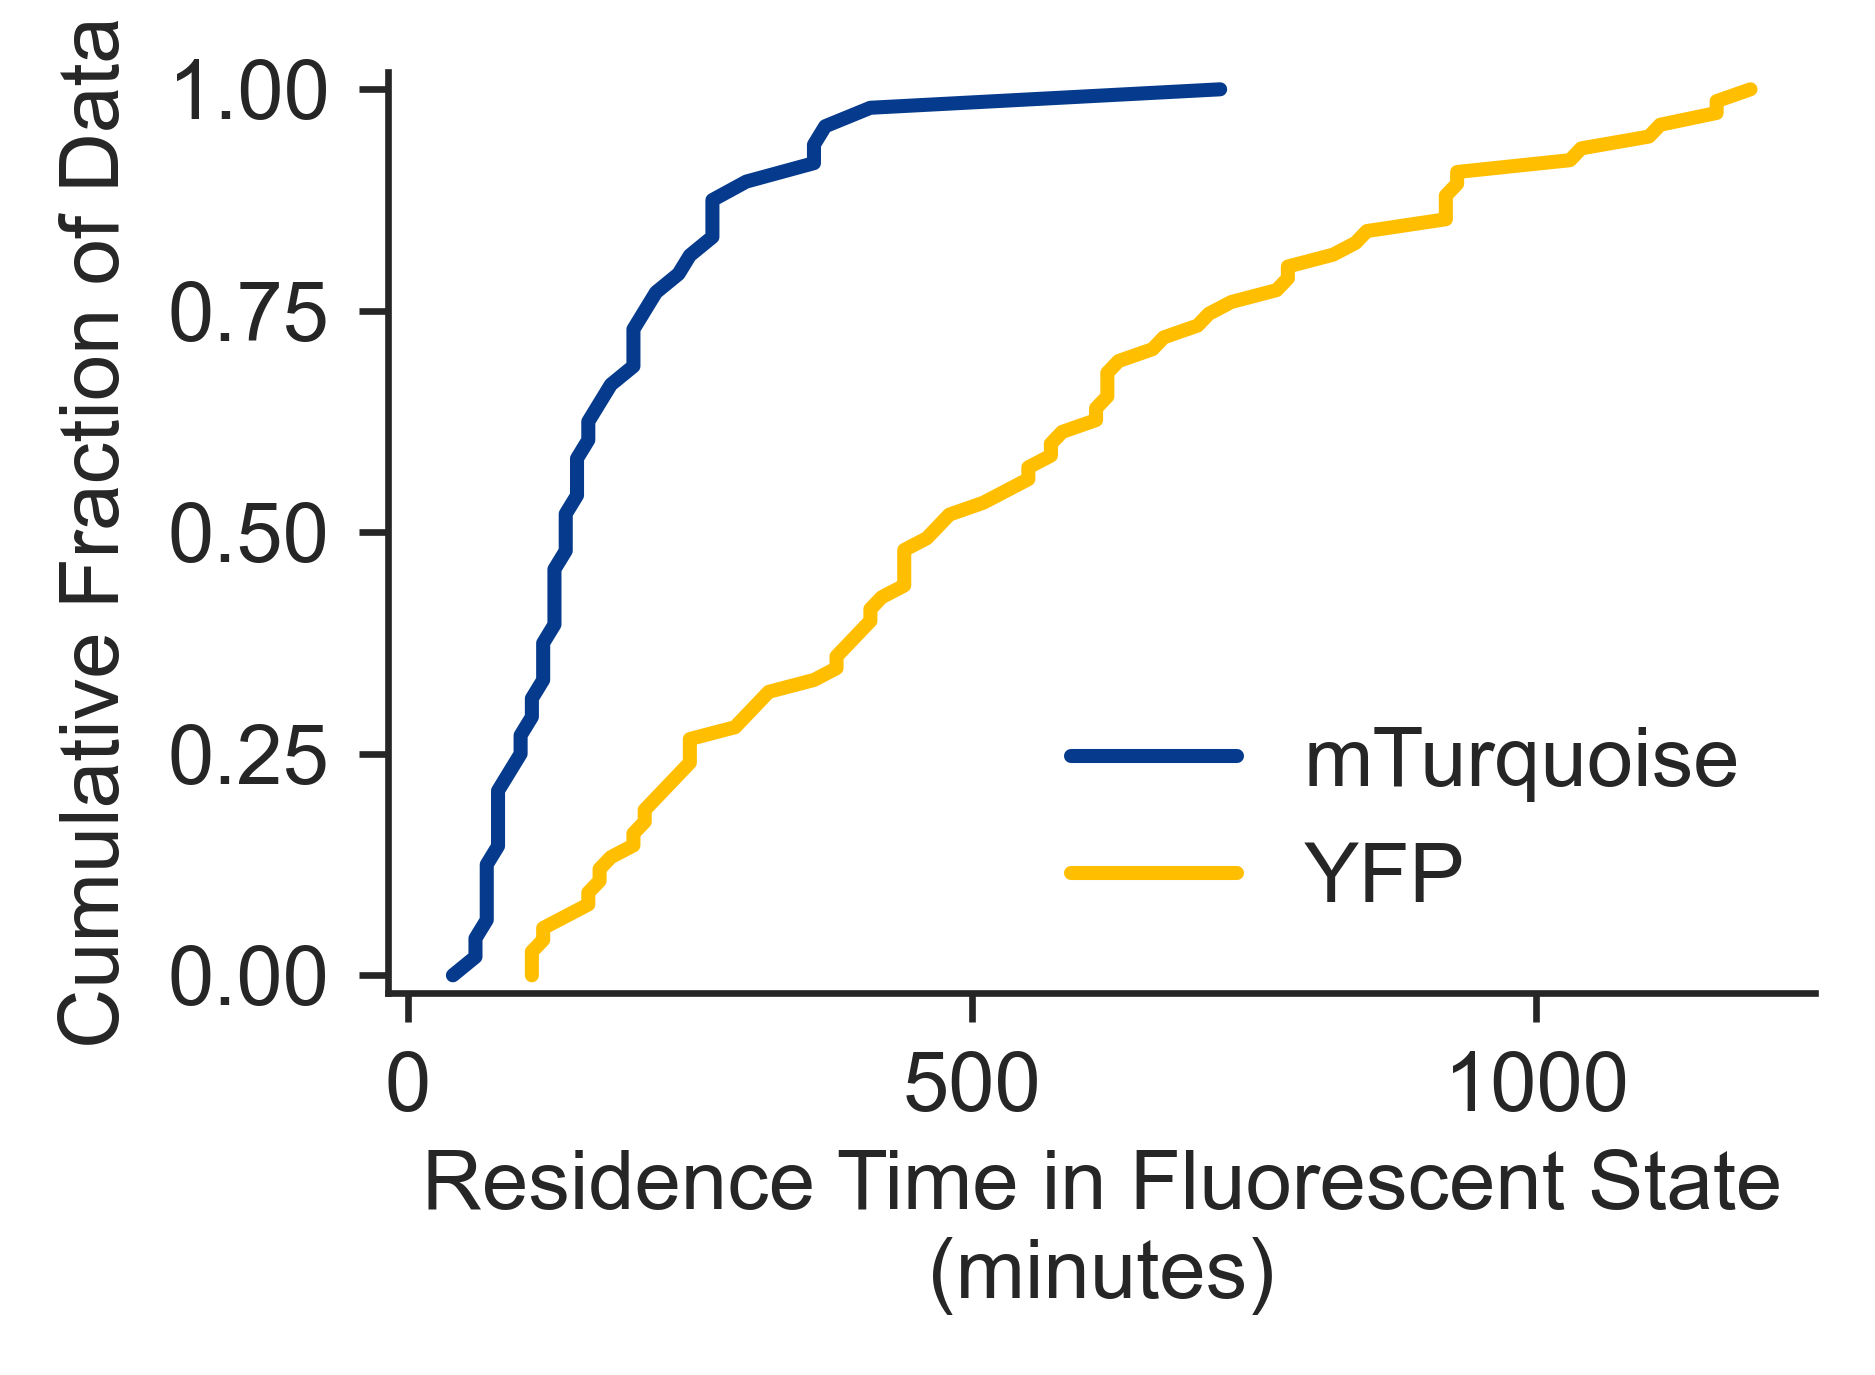

In [10]:
m=9/16
fig,ax = plt.subplots(1,1,figsize=(0.8*7*m,0.85*5*m),dpi=300)
plt.plot(np.sort(to_yellow*10), np.linspace(0, 1, len(to_yellow), endpoint=True),lw=3*m,c='#053a8d',label='mTurquoise')
plt.plot(np.sort(to_blue*10), np.linspace(0, 1, len(to_blue), endpoint=True),lw=3*m,c='#ffbf00',label='YFP')
plt.xlabel('Residence Time in Fluorescent State\n(minutes)', family='Arial',size=17.77*m,labelpad=5*m)
ax.set_ylim(-0.02,1.02)
plt.ylabel('Cumulative Fraction of Data', family='Arial',size=17.77*m,labelpad=7*m)
ax.tick_params(axis='both', which='major', labelsize=17.77*m)
ax.legend(fontsize=17.77*m,frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
plt.tight_layout()

### Composition control figure

/var/folders/sk/lmgspgwj57bfypl3k_8hs9t40000gn/T/ipykernel_28294/2466478874.py:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(ts,np.log10(pop_count_YD[:,1]/pop_count_YD[:,0]),lw=3*m,c='#ffbf00',label=' ')


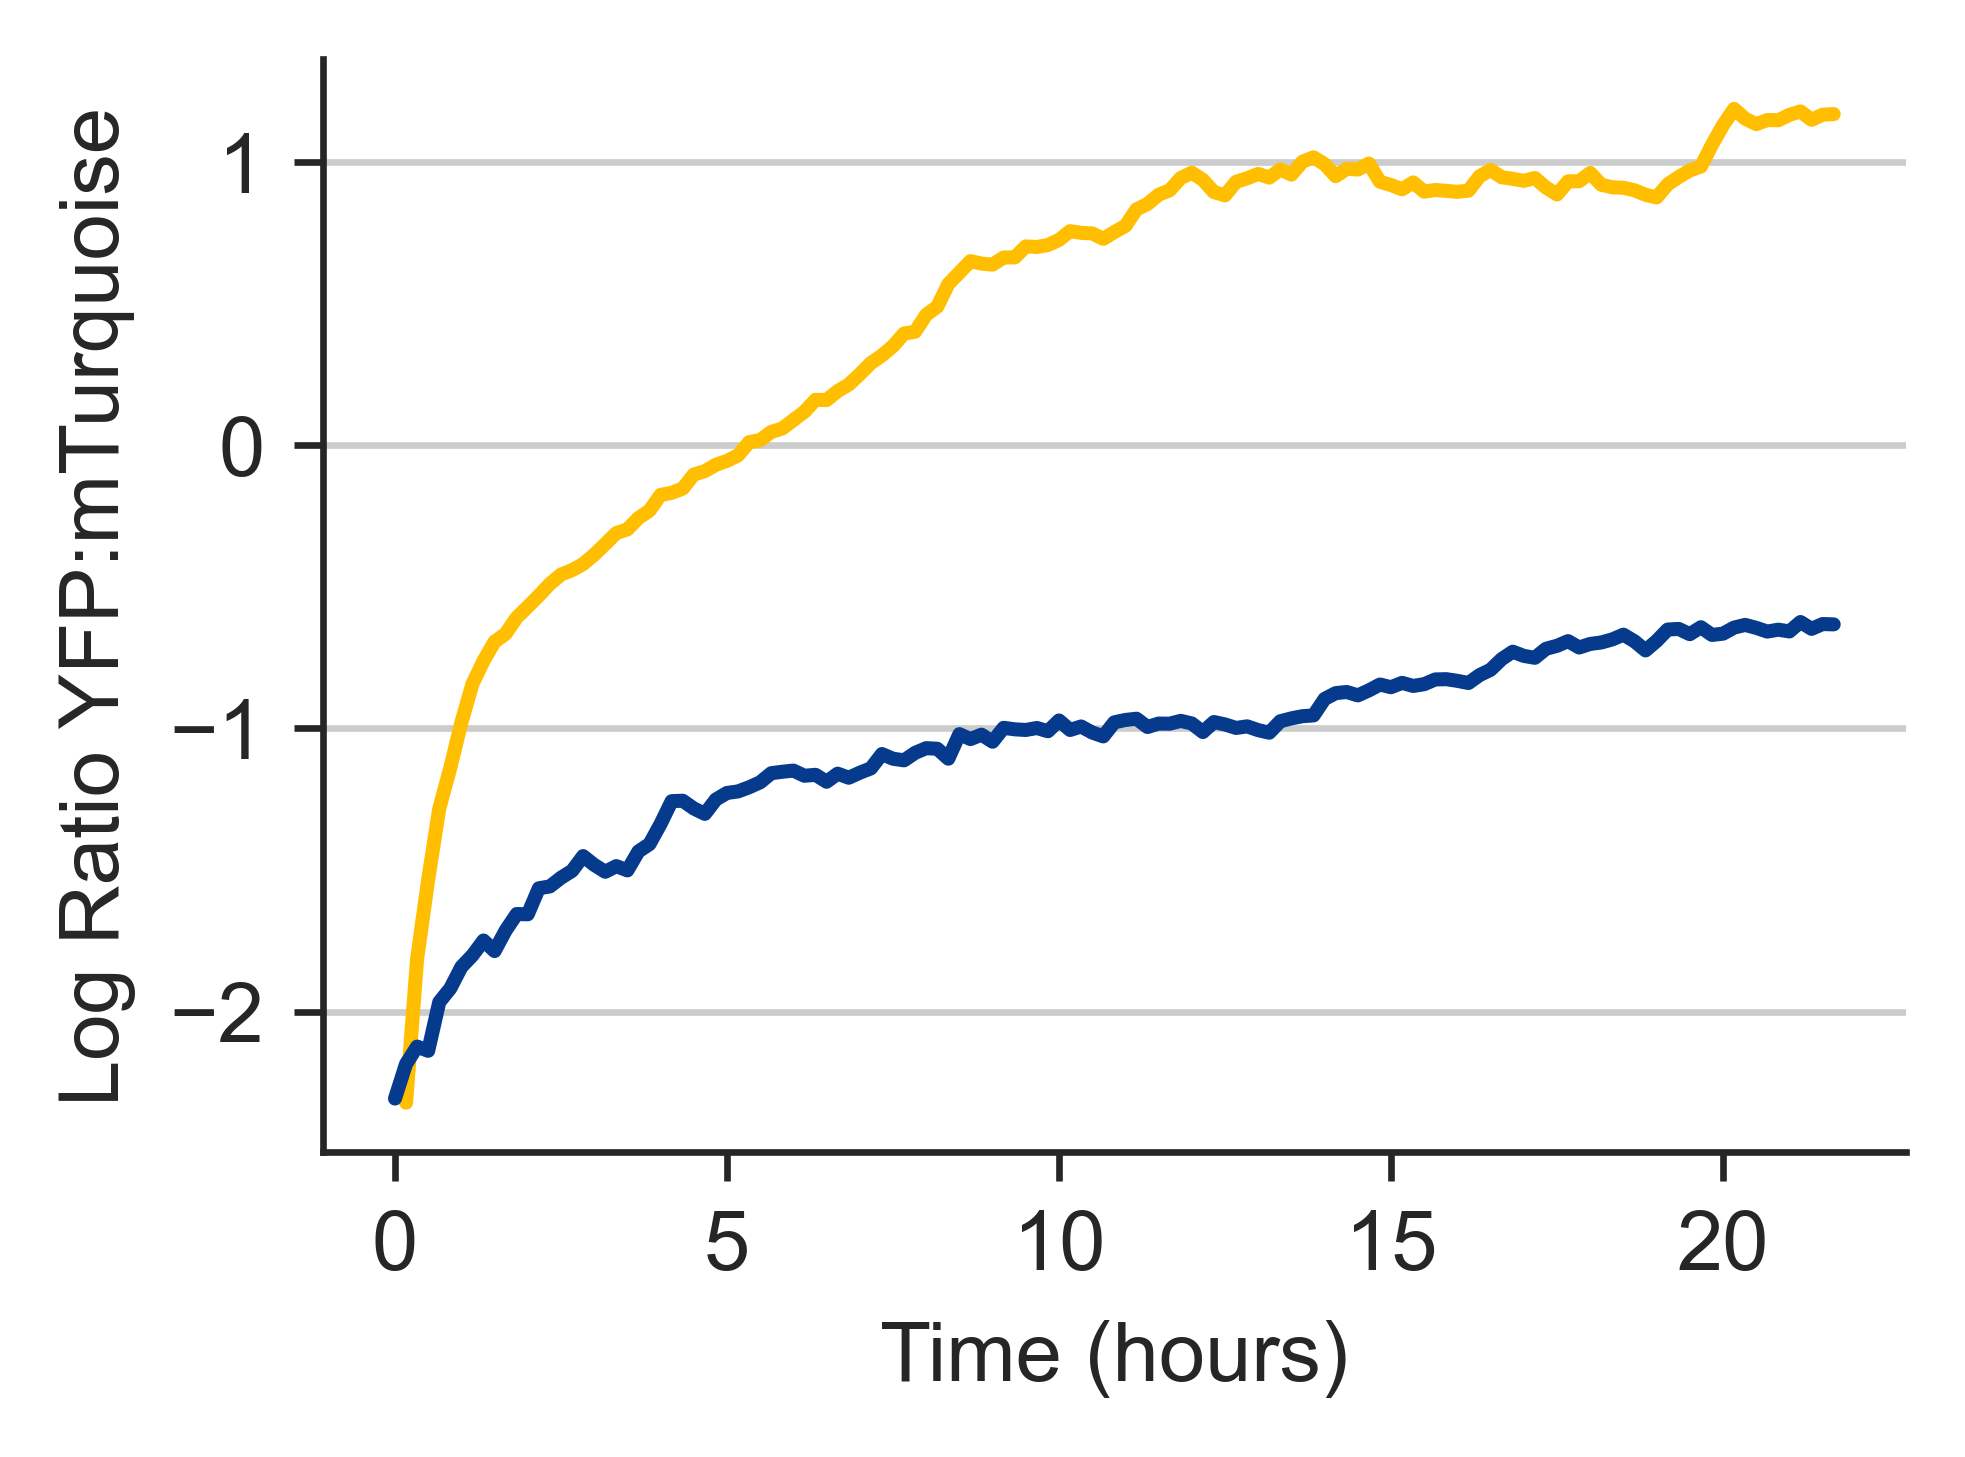

In [11]:
m=9/16
fm=0.75
fig,ax = plt.subplots(1,1,figsize=(8*m*fm,6*m*fm),dpi=300)
ts = np.array(list(range(0,movie_len*10,10)))/60
ax.plot(ts,np.log10(pop_count_YD[:,1]/pop_count_YD[:,0]),lw=3*m,c='#ffbf00',label=' ')
ax.plot(ts,np.log10(pop_count_TD[:,1]/pop_count_TD[:,0]),lw=3*m,c='#053a8d',label=' ')


ax.set_xlabel('Time (hours)',size=17.77*m)
ax.set_ylabel('Log Ratio YFP:mTurquoise',size=17.77*m)
ax.tick_params(axis='both', which='major', labelsize=17.77*m)
intervals = 1
loc = plticker.MultipleLocator(base=intervals)
ax.yaxis.set_major_locator(loc)
ax.grid(which='major', axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

## Supplement Figures

### Individual Population Traces

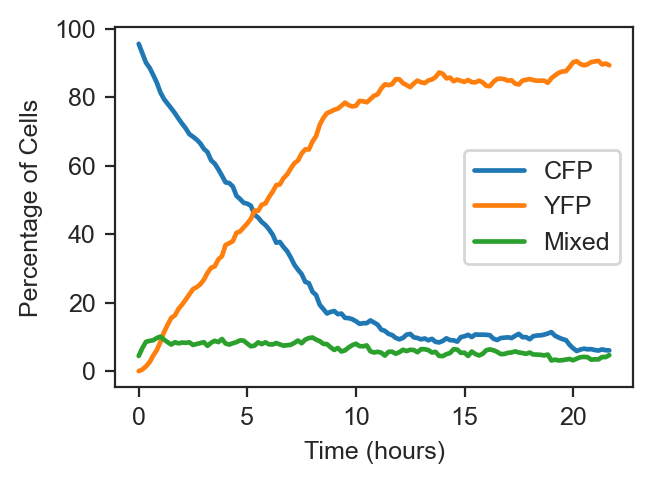

In [12]:
fig,ax = plt.subplots(1,1,figsize=(8*m*fm,6*m*fm))
cell_viable_sum_YD = pop_count_YD[:,1]+pop_count_YD[:,0]+pop_count_YD[:,2]
ts = np.array(list(range(0,movie_len*10,10)))/60
labels = ['CFP','YFP','Mixed']
for i in range(0,3):
    ax.plot(ts,100*pop_count_YD[:,i]/cell_viable_sum_YD,label=labels[i],lw=3*m)

ax.legend(fontsize=16*m) 
ax.set_xlabel('Time (hours)',size=16*m)
ax.set_ylabel("Percentage of Cells",size=16*m)
ax.tick_params(axis='both', which='major', labelsize=16*m)

plt.tight_layout()

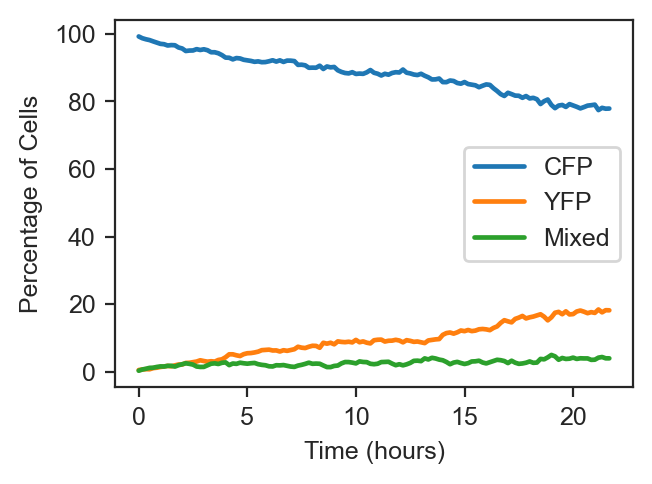

In [13]:
fig,ax = plt.subplots(1,1,figsize=(8*m*fm,6*m*fm))
cell_viable_sum_TD = pop_count_TD[:,1]+pop_count_TD[:,0]+pop_count_TD[:,2]
ts = np.array(list(range(0,movie_len*10,10)))/60
labels = ['CFP','YFP','Mixed']
for i in range(0,3):
    ax.plot(ts,100*pop_count_TD[:,i]/cell_viable_sum_TD,label=labels[i],lw=3*m)

ax.legend(fontsize=16*m) 
ax.set_xlabel('Time (hours)',size=16*m)
ax.set_ylabel("Percentage of Cells",size=16*m)
ax.tick_params(axis='both', which='major', labelsize=16*m)

plt.tight_layout()

### Dim/Dead Cells and Live Cell Traces

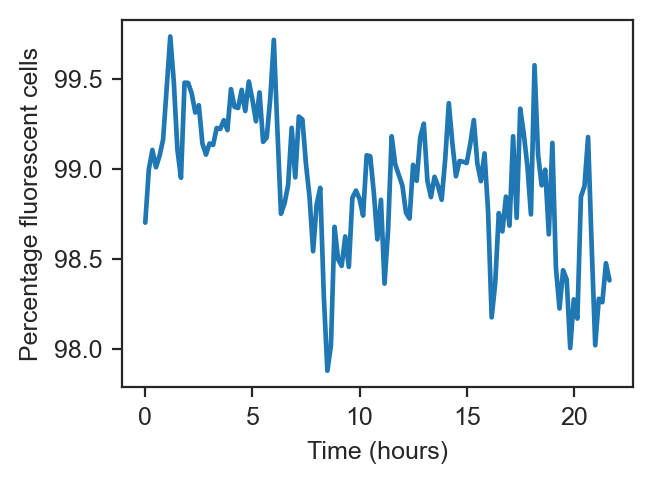

In [14]:
fig,ax = plt.subplots(1,1,figsize=(8*m*fm,6*m*fm))
ax.plot(ts,100*cell_viable_sum_YD/(cell_viable_sum_YD+pop_count_YD[:,3]),lw=3*m)
ax.set_xlabel('Time (hours)',size=16*m)
ax.set_ylabel('Percentage fluorescent cells',size=16*m)
ax.tick_params(axis='both', which='major', labelsize=16*m)
plt.tight_layout()

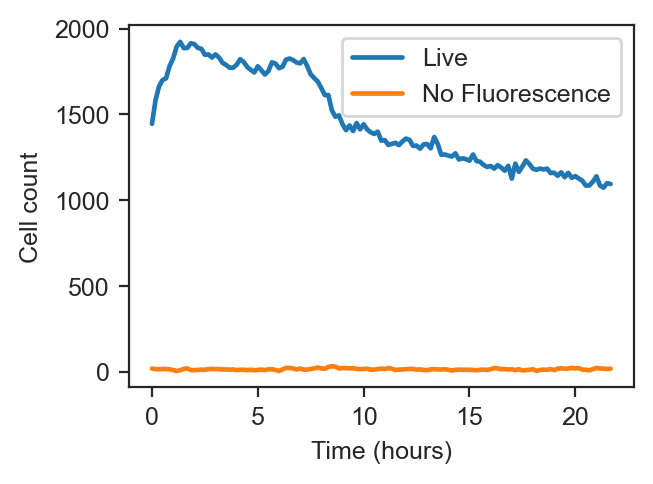

In [15]:
fig,ax = plt.subplots(1,1,figsize=(8*m*fm,6*m*fm))
ax.plot(ts,cell_viable_sum_YD,label='Live',lw=3*m)
ax.plot(ts,pop_count_YD[:,3],label='No Fluorescence',lw=3*m)
ax.set_xlabel('Time (hours)',size=16*m)
ax.set_ylabel('Cell count',size=16*m)
ax.tick_params(axis='both', which='major', labelsize=16*m)
ax.legend(fontsize=16*m,loc=1) 
plt.tight_layout()

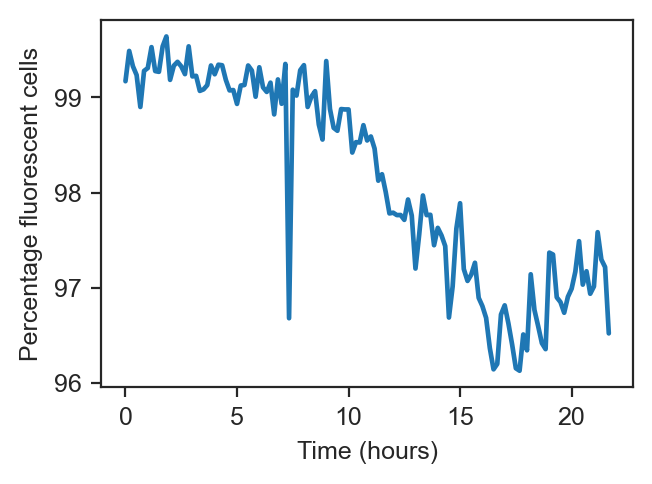

In [16]:
fig,ax = plt.subplots(1,1,figsize=(8*m*fm,6*m*fm))
ax.plot(ts,100*cell_viable_sum_TD/(cell_viable_sum_TD+pop_count_TD[:,3]),lw=3*m)
ax.set_xlabel('Time (hours)',size=16*m)
ax.set_ylabel('Percentage fluorescent cells',size=16*m)
ax.tick_params(axis='both', which='major', labelsize=16*m)
plt.tight_layout()

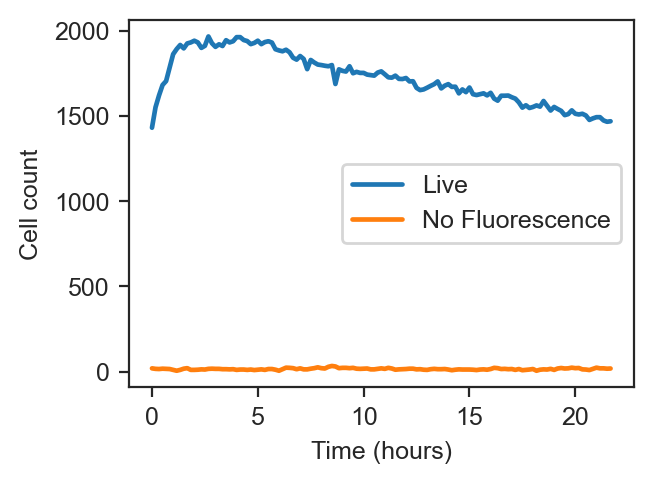

In [17]:
fig,ax = plt.subplots(1,1,figsize=(8*m*fm,6*m*fm))
ax.plot(ts,cell_viable_sum_TD,label='Live',lw=3*m)
ax.plot(ts,pop_count_YD[:,3],label='No Fluorescence',lw=3*m)
ax.set_xlabel('Time (hours)',size=16*m)
ax.set_ylabel('Cell count',size=16*m)
ax.tick_params(axis='both', which='major', labelsize=16*m)
ax.legend(fontsize=16*m,loc=7) 
plt.tight_layout()

## Green cell abundance head-to-head

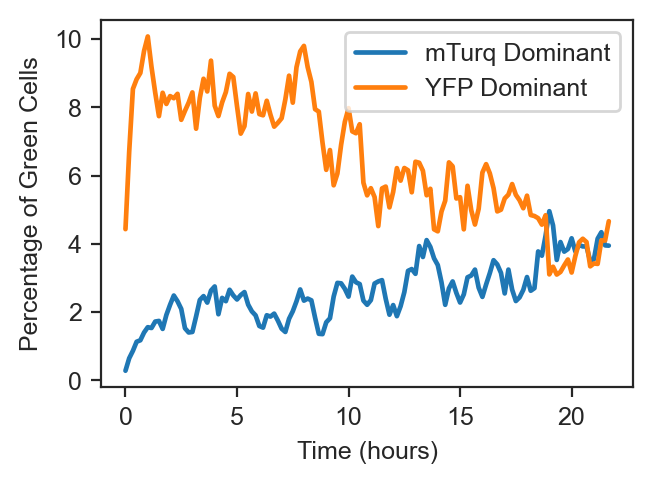

In [18]:
fig,ax = plt.subplots(1,1,figsize=(8*m*fm,6*m*fm))
ax.plot(ts,100*pop_count_TD[:,2]/cell_viable_sum_TD,label='mTurq Dominant',lw=3*m)
ax.plot(ts,100*pop_count_YD[:,2]/cell_viable_sum_YD,label='YFP Dominant',lw=3*m)
ax.legend(fontsize=16*m) 
ax.set_xlabel('Time (hours)',size=16*m)
ax.set_ylabel("Percentage of Green Cells",size=16*m)
ax.tick_params(axis='both', which='major', labelsize=16*m)
plt.tight_layout()